#Neural Network Classification - Binary Classification

---



##Make classification data

In [ ]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise = 0.03, random_state=42)

In [ ]:
X[:5],y[:5], X.shape, y.shape

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]),
 (1000, 2),
 (1000,))

In [ ]:
# Make DataFrame of circle data
circles = pd.DataFrame({"X1" : X[:,0], "X2" : X[:,1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


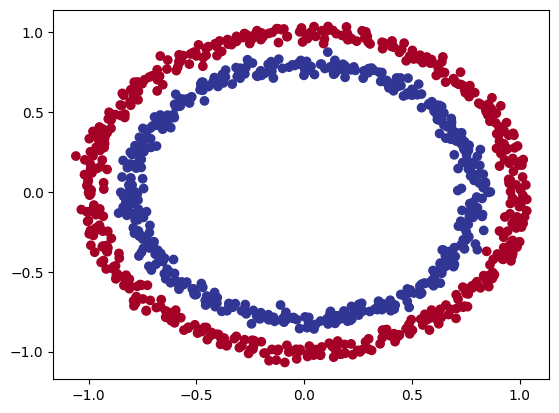

In [ ]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

##Turning data into tensors

In [ ]:
import torch
torch.__version__

'2.0.0+cu118'

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

##Building a Model

In [ ]:
# Setup device agnostic code
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

###Construct a Model

*  Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
*  Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
*  Defines a forward() method containing the forward pass computation of the model.
*  Instantiates the model class and sends it to the target device.

In [ ]:
# Subclass nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create nn.Linear layers capable of handling the input data
    self.layer_1 = nn.Linear(in_features=2, out_features=8) # Input layer - in_features = size of input data, out_features = size of next hidden layer
    self.layer_2 = nn.Linear(in_features=8, out_features=1) # Hidden layer - in_features = output of the input layer, out_features = size of next hidden layer or size of output data

  # Define forward method
  def forward(self, x)  :
    return self.layer_2(self.layer_1(x)) # Input -> layer1 -> layer2

# Instantiate an instance of the model class
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

###Constructing same model using nn.Sequential

In [ ]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6805,  0.6170],
                      [-0.6126,  0.2496],
                      [-0.2494,  0.0299],
                      [ 0.3837, -0.4292],
                      [ 0.0619,  0.6035],
                      [ 0.1775, -0.1147],
                      [-0.4357, -0.3539],
                      [ 0.4067,  0.4091]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.2552,  0.3365,  0.0442, -0.3953, -0.5117, -0.3290,  0.4677,  0.5314],
                     device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0466, -0.1248, -0.0246,  0.0969, -0.3296,  0.2925,  0.0206, -0.2655]],
                     device='cuda:0')),
             ('1.bias', tensor([-0.3326], device='cuda:0'))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

untrained_preds[:10], untrained_preds.shape, y_test[:10], y_test.shape

(tensor([[-0.7543],
         [-0.8375],
         [-0.3839],
         [-0.8598],
         [-0.1422],
         [-0.1949],
         [-0.6207],
         [-0.4696],
         [-0.3946],
         [-0.8404]], device='cuda:0'),
 torch.Size([200, 1]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 torch.Size([200]))

###Setup loss function and optimiser

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # Built in with sigmoid activation function

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

###Caluclate Accuracy

In [ ]:
def accuracy_fn(y_true, y_pred):
    y_true = y_true.to(device)
    y_pred = y_pred.to(device)
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

##Train the Model

###Raw logits > Prediction probabilities > prediction labels

*  Use sigmoid activation to turn logits to prediction probabilities
*  Use rounding to convert to labels & using squeeze to reduce extra dimension

In [ ]:
with torch.inference_mode():
  y_pred_logits = model_0(X_test.to(device))

y_pred_logits[:10], y_pred_logits.shape

(tensor([[-0.7543],
         [-0.8375],
         [-0.3839],
         [-0.8598],
         [-0.1422],
         [-0.1949],
         [-0.6207],
         [-0.4696],
         [-0.3946],
         [-0.8404]], device='cuda:0'),
 torch.Size([200, 1]))

In [ ]:
y_test[:10], y_test.shape

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]), torch.Size([200]))

In [ ]:
# Using sigmoid activation to convert to prediction probabilities

y_pred_probs = torch.sigmoid(y_pred_logits)
y_pred_probs[:10], y_pred_probs.shape

(tensor([[0.3199],
         [0.3021],
         [0.4052],
         [0.2974],
         [0.4645],
         [0.4514],
         [0.3496],
         [0.3847],
         [0.4026],
         [0.3015]], device='cuda:0'),
 torch.Size([200, 1]))

In [ ]:
# Rounding up the probabilities to get labels and reducing extra dimension

y_pred_labels = torch.round(y_pred_probs).squeeze()
y_pred_labels[:10], y_pred_labels.shape

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
 torch.Size([200]))

In [ ]:
accuracy_fn(y_test, y_pred_labels)

50.0

###Building a training and testing loop

In [ ]:
# Set Epochs
epochs = 500

# Put data in target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):

  model_0.train()

  # TRAINING LOOP

  # Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss
  loss = loss_fn(y_logits, y_train) #BCE with logits requires logits as input

  acc = accuracy_fn(y_train, y_pred)

  # Optimizer zero gradient
  optimizer.zero_grad()

  # Backward Propogation
  loss.backward()

  # Gradient Descent
  optimizer.step()

  # TESTING LOOP

  model_0.eval()
  with torch.inference_mode():

    # Forward Pass
    y_test_logits = model_0(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    # Calculate Loss
    loss_test = loss_fn(y_test_logits, y_test)

    test_acc = accuracy_fn(y_test, y_test_pred)

  # Print training details
  if epoch % 10 == 0 :
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {loss_test:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72845, Accuracy: 50.00% | Test loss: 0.72190, Test acc: 50.00%
Epoch: 10 | Loss: 0.72514, Accuracy: 50.00% | Test loss: 0.71856, Test acc: 50.00%
Epoch: 20 | Loss: 0.72219, Accuracy: 50.00% | Test loss: 0.71558, Test acc: 50.00%
Epoch: 30 | Loss: 0.71955, Accuracy: 48.88% | Test loss: 0.71294, Test acc: 50.00%
Epoch: 40 | Loss: 0.71719, Accuracy: 47.12% | Test loss: 0.71058, Test acc: 49.50%
Epoch: 50 | Loss: 0.71508, Accuracy: 44.38% | Test loss: 0.70849, Test acc: 46.00%
Epoch: 60 | Loss: 0.71320, Accuracy: 43.00% | Test loss: 0.70662, Test acc: 45.00%
Epoch: 70 | Loss: 0.71151, Accuracy: 41.50% | Test loss: 0.70496, Test acc: 42.50%
Epoch: 80 | Loss: 0.70999, Accuracy: 41.12% | Test loss: 0.70348, Test acc: 41.50%
Epoch: 90 | Loss: 0.70863, Accuracy: 41.38% | Test loss: 0.70216, Test acc: 43.50%
Epoch: 100 | Loss: 0.70741, Accuracy: 43.62% | Test loss: 0.70099, Test acc: 45.50%
Epoch: 110 | Loss: 0.70632, Accuracy: 44.50% | Test loss: 0.69994, Test acc: 46.50%
Epo

###Make predictions and evaluate

In [ ]:
import requests
from pathlib import Path

In [ ]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


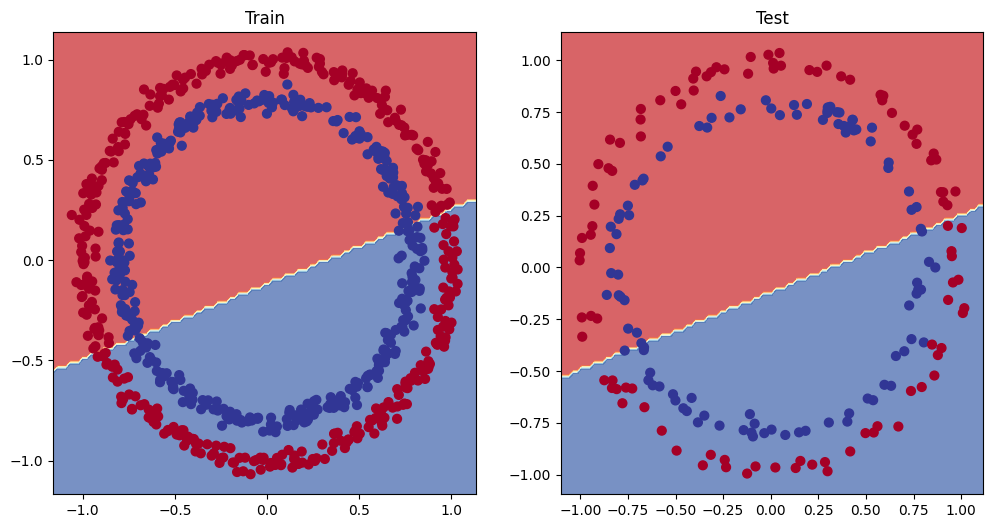

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

##Improve the Model

*  Adding more layers
*  Fit for longer
*  Changing activation functions
*  Change the learning rate
*  Change the loss function
*  Use transfer learninig

###Add more layers and run more epochs

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=16)
    self.layer_2 = nn.Linear(in_features=16, out_features=16)
    self.layer_3 = nn.Linear(in_features=16, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  # TRAINING

  # Forward Pass
  y_pred_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_pred_logits))

  # Calculate loss
  loss = loss_fn(y_pred_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # Optimizer Zero-Grad
  optimizer.zero_grad()

  # Back propogation
  loss.backward()

  # Gradient Descent
  optimizer.step()

  # TESTING

  model_1.eval()
  with torch.inference_mode():

    # Forward Pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    # Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  # Print training data
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 100 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 200 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


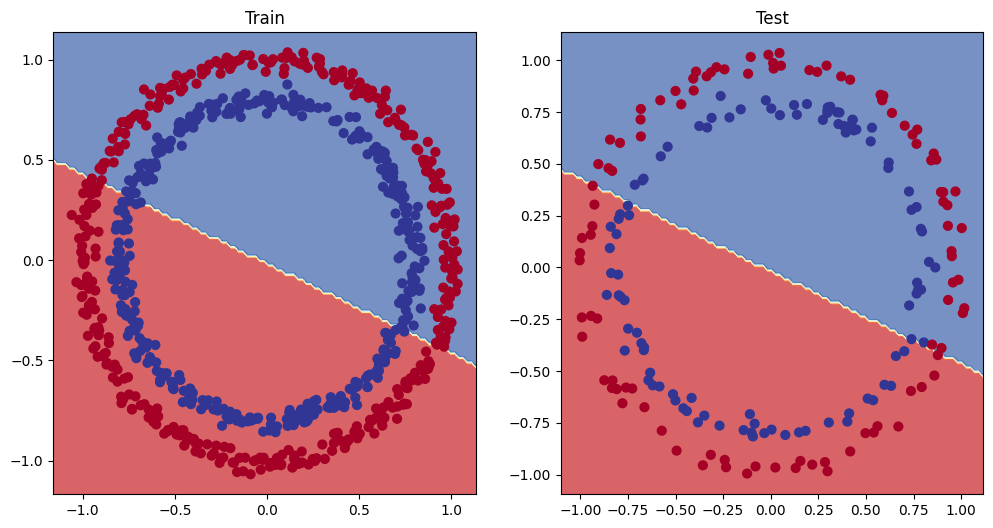

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

###Training a model with non-linearity

In [ ]:
# Model with non-linear activation function

class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU() # Non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1200

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  # TRAINING

  # Forward Pass
  y_pred_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_pred_logits))

  # Calculate loss
  loss = loss_fn(y_pred_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # Optimizer Zero-Grad
  optimizer.zero_grad()

  # Back propogation
  loss.backward()

  # Gradient Descent
  optimizer.step()

  # TESTING

  model_3.eval()
  with torch.inference_mode():

    # Forward Pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    # Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  # Print training data
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.01050, Accuracy: 100.00% | Test loss: 0.02616, Test acc: 99.50%
Epoch: 100 | Loss: 0.00992, Accuracy: 100.00% | Test loss: 0.02520, Test acc: 99.50%
Epoch: 200 | Loss: 0.00941, Accuracy: 100.00% | Test loss: 0.02435, Test acc: 99.50%
Epoch: 300 | Loss: 0.00896, Accuracy: 100.00% | Test loss: 0.02359, Test acc: 99.50%
Epoch: 400 | Loss: 0.00855, Accuracy: 100.00% | Test loss: 0.02291, Test acc: 99.50%
Epoch: 500 | Loss: 0.00818, Accuracy: 100.00% | Test loss: 0.02229, Test acc: 99.50%
Epoch: 600 | Loss: 0.00784, Accuracy: 100.00% | Test loss: 0.02176, Test acc: 99.50%
Epoch: 700 | Loss: 0.00752, Accuracy: 100.00% | Test loss: 0.02128, Test acc: 99.50%
Epoch: 800 | Loss: 0.00723, Accuracy: 100.00% | Test loss: 0.02088, Test acc: 99.50%
Epoch: 900 | Loss: 0.00697, Accuracy: 100.00% | Test loss: 0.02051, Test acc: 99.50%
Epoch: 1000 | Loss: 0.00672, Accuracy: 100.00% | Test loss: 0.02016, Test acc: 99.50%
Epoch: 1100 | Loss: 0.00649, Accuracy: 100.00% | Test loss: 0.0198

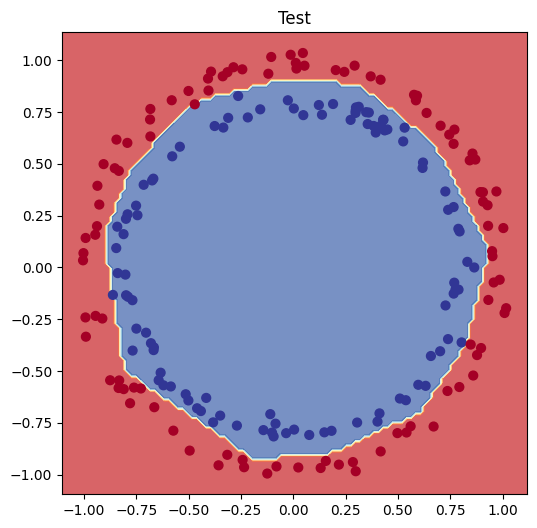

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(6, 6))
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

#Multi-class Classification Model

##Creating Data

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
# Set the hyper-parameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [ ]:
# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
X_blob[:10], y_blob[:10], X_blob.shape, y_blob.shape

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815],
         [-6.7941, -6.4772],
         [ 5.2102,  2.8890],
         [-5.5051, -6.3604],
         [-6.5438, -4.8339],
         [ 6.4496,  0.7478]]),
 tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1]),
 torch.Size([1000, 2]),
 torch.Size([1000]))

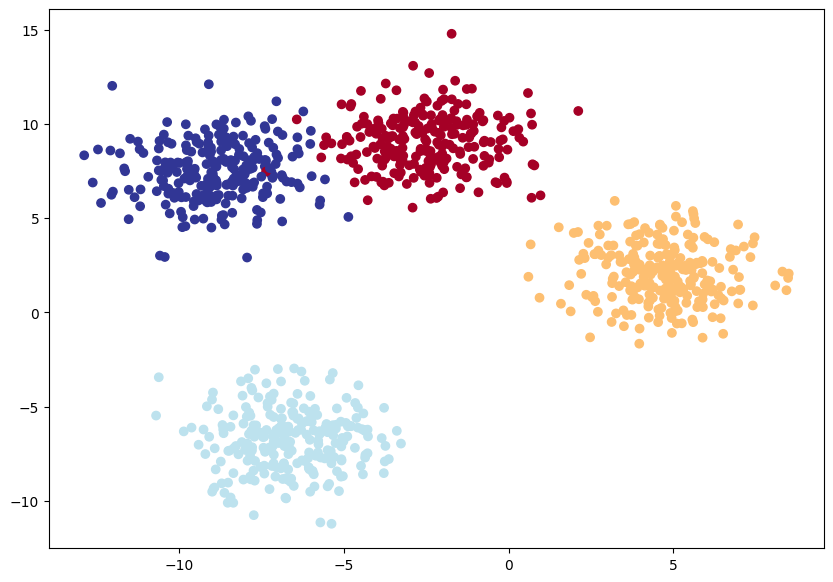

In [ ]:
# Split data into train and test data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state = RANDOM_SEED)

# Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);

##Building a multi-class classification model

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn

# Build Model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

###Creating loss function and optimiser

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

###Testing the untrained model

In [ ]:
model_4(X_blob_train.to(device)).shape
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
untrained_logits = model_4(X_blob_train.to(device))
untrained_preds = torch.softmax(untrained_logits, dim=1) # Softmax used to generate probabilities from logits. 4 probabilities for each possible class are generated
untrained_preds = torch.argmax(untrained_preds, dim=1) # Selects and stores the max probability

untrained_preds.shape, untrained_preds[:50]

(torch.Size([800]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
         3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         1, 0], device='cuda:0'))

### Creating training and testing loops

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data in target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

  # TRAINING

  model_4.train()

  # Forward Pass
  y_pred_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_pred_logits, dim=1).argmax(dim=1)

  # Calculate Loss
  loss = loss_fn(y_pred_logits, y_blob_train)
  acc = accuracy_fn(y_train, y_pred)

  # Optimiser Zero Grad
  optimizer.zero_grad()

  # Back propogation
  loss.backward()

  # Gradient Descent
  optimizer.step()

  # TESTING

  model_4.eval()
  with torch.inference_mode():

    # Forward Pass
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # Calculate Loss
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_preds)

  # Print training data
  if epoch % 10 == 0 :
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 47.88% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 27.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 26.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 26.62% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 26.62% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 26.62% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 26.62% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 26.62% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 26.62% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 26.62% | Test Loss: 0.02663, Test Acc: 99.50%


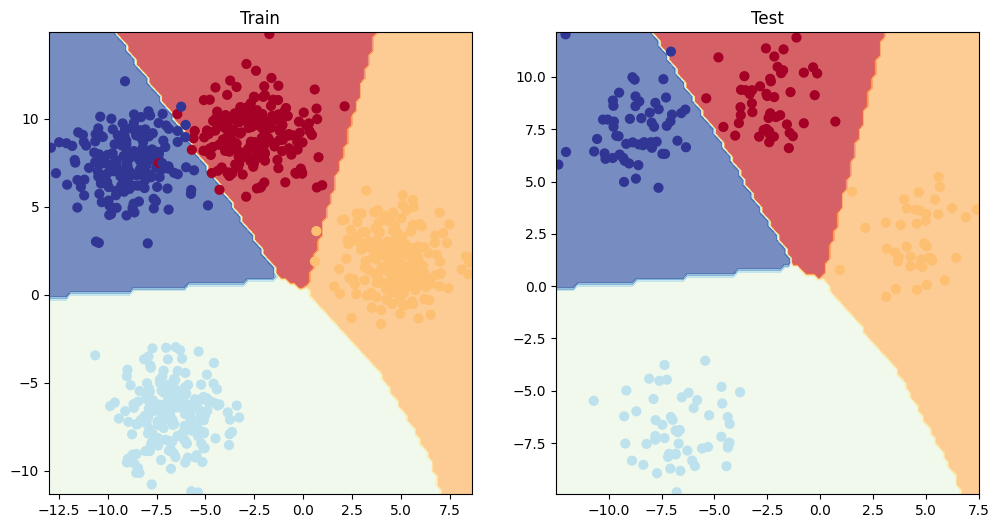

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)